In [2]:
%load_ext autoreload

In [5]:
%autoreload 2

from koopmaneigen.koopman_eigensolver_dmd import KoopmanEigenSolversDMD
from koopmaneigen.linearsystem import Linear2dSystem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity

### set up linear system Koopman matrix using EDMD

In [6]:
A = np.array([[0.9, -0.1], [0, 0.8]])

eigvalue_i = 0.9
eigvalue_j = 0.8

def eigenfunction_i(x,y):
    return (x-y)/np.sqrt(2)

def eigenfunction_j(x,y):
    return y    

linear_system = Linear2dSystem(A, eigvalue_i, eigvalue_j, eigenfunction_i, eigenfunction_j)

In [7]:
initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)


initial_conditions.shape

(400, 2)

In [8]:
tsc_data = linear_system.sample_system(initial_conditions)
print(tsc_data.shape)
tsc_data.head()

(800, 2)


feature        x1        x2
ID time                    
0  0    -2.000000 -2.000000
   1    -1.600000 -1.600000
1  0    -2.000000 -1.789474
   1    -1.621053 -1.431579
2  0    -2.000000 -1.578947

#### Approximate Koopman matrix using DMD

In [9]:
dmd = DMDFull().fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.arange(0,10))

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature         x1        x2
ID  time                    
0   0    -2.000000 -2.000000
    1    -1.600000 -1.600000
1   0    -2.000000 -1.789474
    1    -1.621053 -1.431579
2   0    -2.000000 -1.578947
...            ...       ...
397 1     1.642105  1.263158
398 0     2.000000  1.789474
    1     1.621053  1.431579
399 0     2.000000  2.000000
    1     1.600000  1.600000

[800 rows x 2 columns]

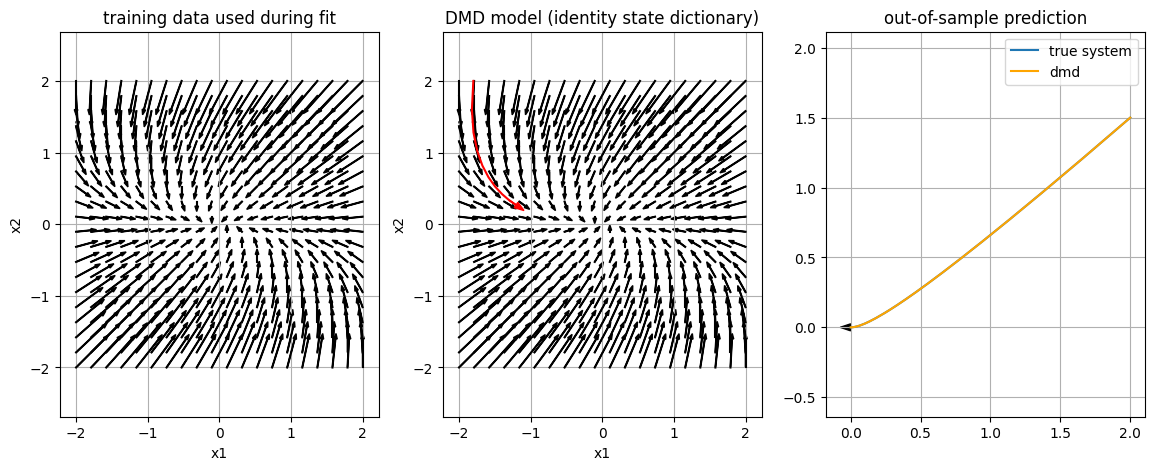

In [18]:
def include_arrow(ax, df, color="black", hw = 0.05):
        ax.arrow(
            df.iloc[-2, 0],
            df.iloc[-2, 1],
            dx=df.iloc[-1, 0] - df.iloc[-2, 0],
            dy=df.iloc[-1, 1] - df.iloc[-2, 1],
            color=color,
            head_width=hw,
        )
  
f, ax = plt.subplots(1, 3, figsize=(14, 5))
for _id, df in tsc_data.itertimeseries():
    ax[0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[0], df)
    
ax[0].set_title("training data used during fit")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis("equal")
ax[0].grid()

for _id, df in dmd_values.itertimeseries():
    ax[1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
    include_arrow(ax[1], df)

ax[1].set_title("DMD model (identity state dictionary)")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
ax[1].axis("equal")
ax[1].grid()


# generate red "out-of-sample" prediction, for extra analysis below
ax[1].plot(dmd_values_oos["x1"], dmd_values_oos["x2"], 0.1, c="red")
include_arrow(ax[1], dmd_values_oos, color="red", hw = 0.09)

# compare oos prediction
initial_condition = np.array([[2, 1.5]])

ground_truth = linear_system.generate_trajectory(initial_condition, n_steps=200)
predicted = dmd.predict(initial_condition, np.arange(0,200))

ax[2].plot(ground_truth.loc[:, "x1"], ground_truth.loc[:, "x2"], label="true system")
include_arrow(ax[2], ground_truth)
ax[2].plot(predicted.loc[:, "x1"], predicted.loc[:, "x2"], c="orange", label="dmd")

ax[2].set_title("out-of-sample prediction")
ax[2].axis("equal")
ax[2].grid()
ax[2].legend()
plt.savefig('plots/DMD_linear_system.png', bbox_inches='tight', dpi=300)
plt.show()

#### plot explicit koopman eigenfunctions of the linear system

In [20]:
sorted_eig = linear_system.get_sorted_eigvalues(max_exponent_sum=5)
sorted_eig

[(1, 0),
 (2, 0),
 (0, 1),
 (3, 0),
 (1, 1),
 (4, 0),
 (2, 1),
 (0, 2),
 (5, 0),
 (3, 1),
 (1, 2),
 (4, 1),
 (2, 2),
 (0, 3),
 (3, 2),
 (1, 3),
 (2, 3),
 (0, 4),
 (1, 4),
 (0, 5)]

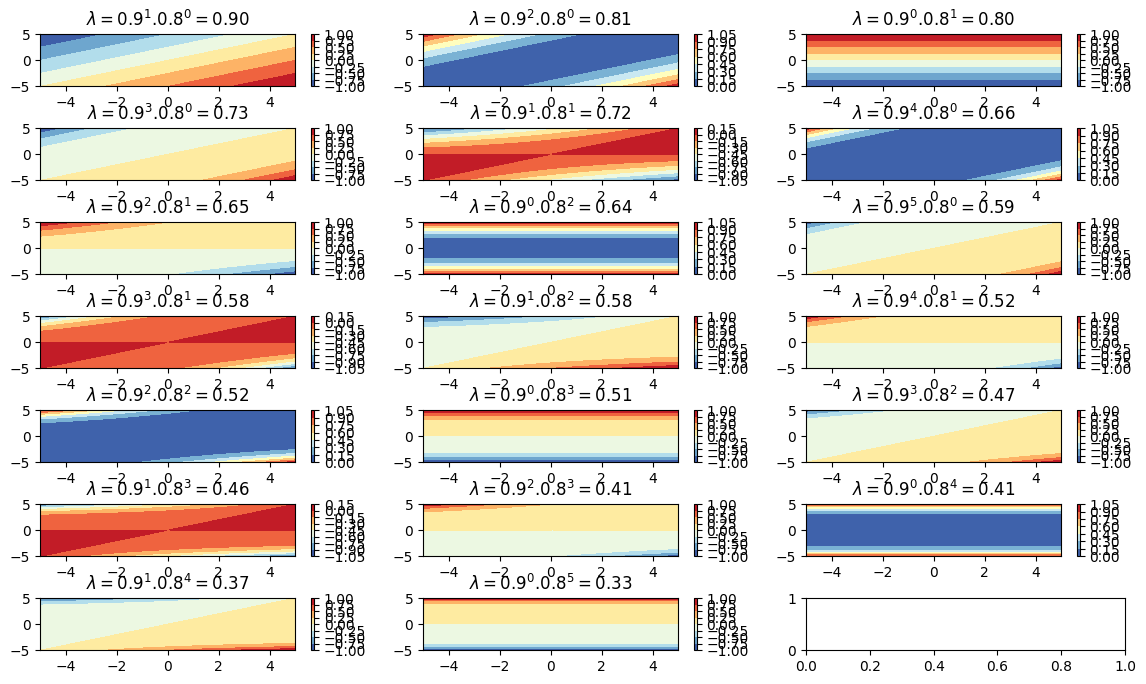

In [21]:
f, ax = plt.subplots(len(sorted_eig)//3 + 1, 3, figsize=(14, 8))
plt.subplots_adjust(hspace=0.8)

# define grid range
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
    
for i, (m,n) in enumerate(sorted_eig):
    linear_system.plot_eigenfunction_contour(x=x, y=y, m=m, n=n, ax = ax[int(i/3)][i%3])
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = f"$\lambda = {eigvalue_i}^{m} . {eigvalue_j}^{n} = {eig:0.2f}$"
    ax[int(i/3)][i%3].set_title(eig_str)



### plot Koopman eigenfunctions computed using left eigenvectors

In [22]:
koopman_eigen_dmd = KoopmanEigenSolversDMD(dmd, tsc_data)
print("shape of koopman matrix: ", koopman_eigen_dmd.koopman_matrix.shape)

shape of koopman matrix:  (2, 2)


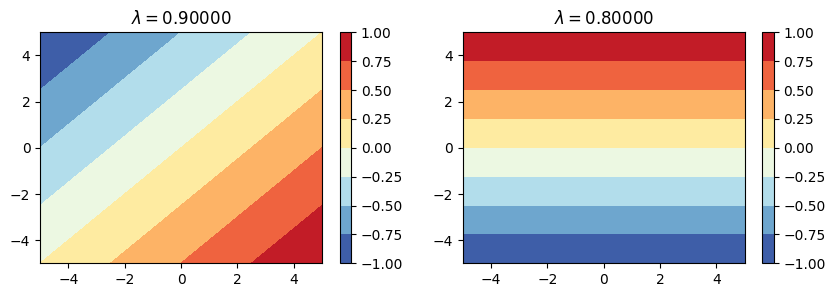

In [23]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(hspace=0.6)

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()
x = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(x)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[i].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen_dmd.left_koopman_eigvals[i]

    ax[i].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    

#### extend eigenfunctions using two left eigenvectors

In [24]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x.shape)
koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=2, pow_j=4)

(100,)


array([2.96831102e-29, 1.02030405e-04, 4.08121620e-04, ...,
       4.08121620e-04, 1.02030405e-04, 2.96831102e-29])

#### compare extended eigenfunctions with explicit eigenfunctions

In [25]:
# take increasing powers of second eigenfunctions to compare
sorted_eig = linear_system.get_sorted_eigvalues(max_exponent_sum=10)

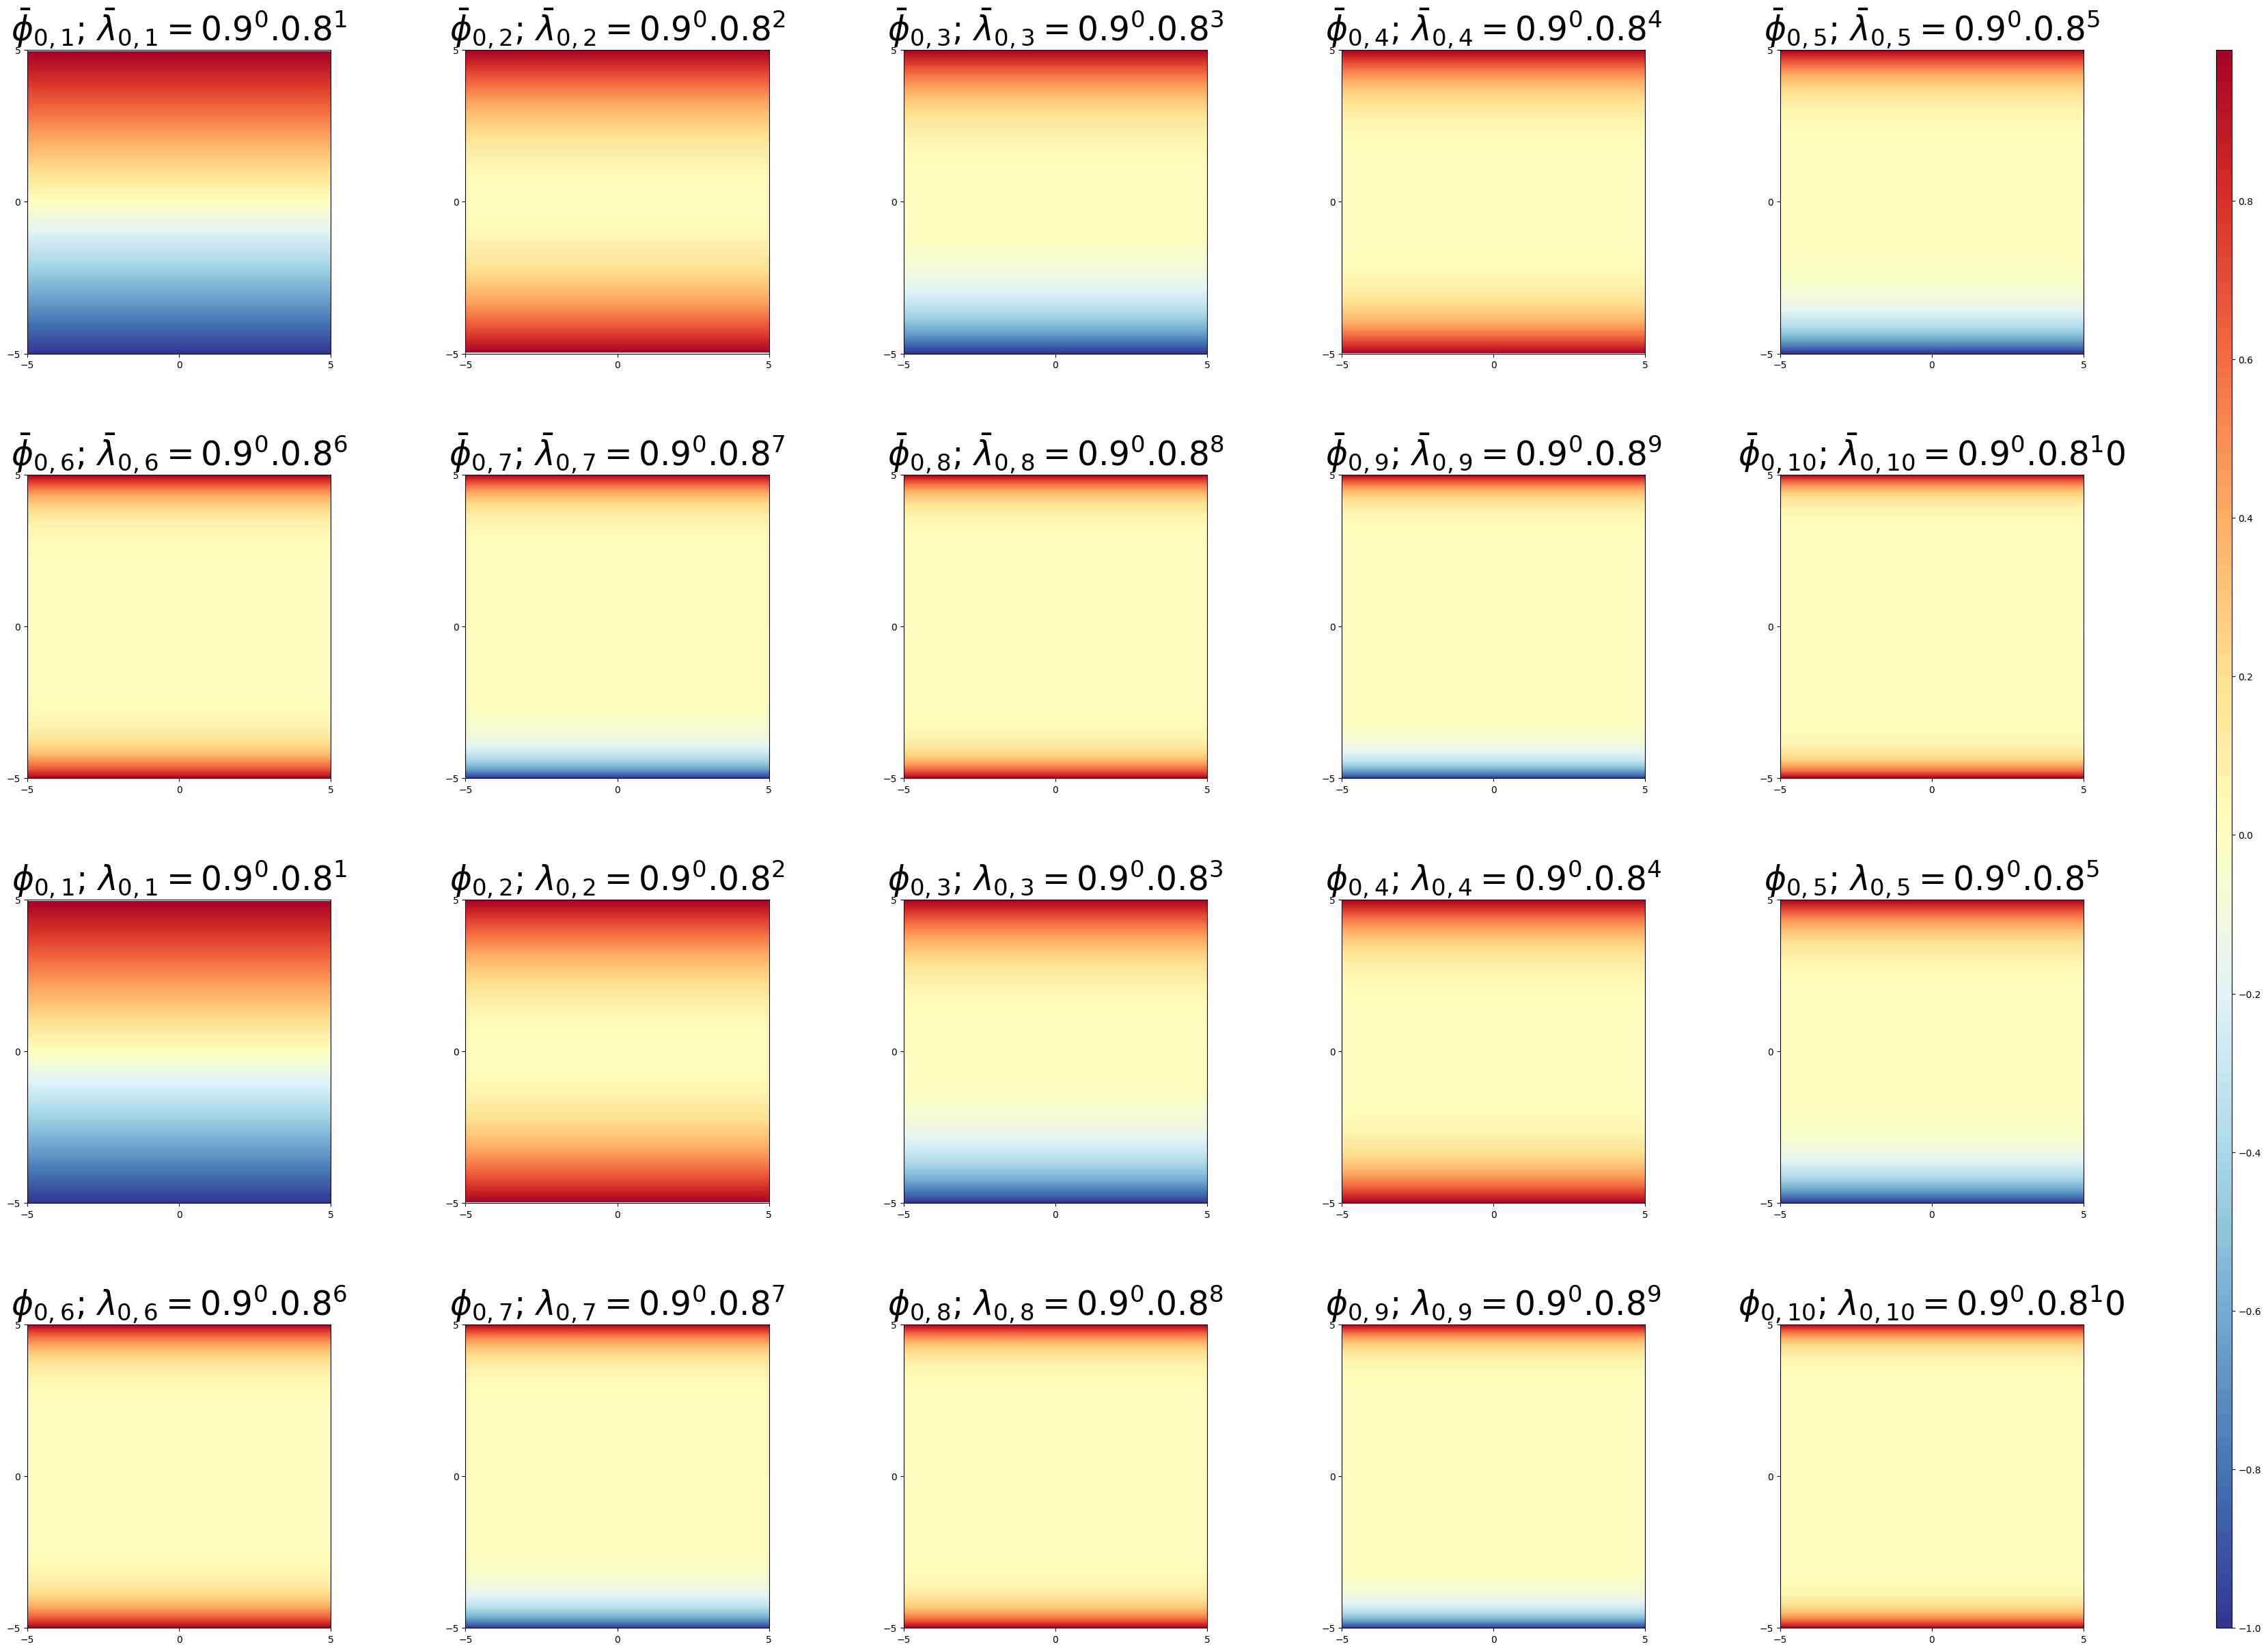

In [26]:
f, ax = plt.subplots(4, 5, figsize=(50,30))
plt.subplots_adjust(hspace=0.4)
error_list = []

c = 0
for i, (m,n) in enumerate(sorted_eig):
    Z_l = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    Z_l = Z_l.reshape(X.shape)
    Z_l_norm = Z_l/np.max(np.abs(Z_l))
    
    eigvalue_i_c = koopman_eigen_dmd.left_koopman_eigvals[0]
    eigvalue_j_c = koopman_eigen_dmd.left_koopman_eigvals[1]
    eig_c = (eigvalue_i_c)**m * (eigvalue_j_c) ** n
    eig_str_c = "$\\bar{\lambda}_{" + f"{m},{n}" + "}" + f"= {eigvalue_i_c:.3}^{m} . {eigvalue_j_c:.3}^{n}$"
    
    if m ==0:
        row = 1 if c>4 else 0
        h = ax[row][c%5].contourf(X, Y, Z_l_norm, cmap='RdYlBu_r', levels=np.arange(-1,1,0.01), vmin=-1, vmax=1)
#         plt.colorbar(h, orientation='horizontal')
        ax[row][c%5].set_title("$\\bar{\phi}_{" + f"{m},{n}" + "}$; " + eig_str_c, fontsize=35)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].set_aspect('equal')

    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    Z_norm = Z/np.max(np.abs(Z))
    
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = "$\lambda_{" + f"{m},{n}" + "}" + f"= {eigvalue_i:.3}^{m} . {eigvalue_j:.3}^{n}$"

    if m ==0:
        row = 3 if c>4 else 2
        h = ax[row][c%5].contourf(X, Y, Z_norm, cmap='RdYlBu_r', levels=np.arange(-1,1,0.01), vmin=-1, vmax=1)
#         plt.colorbar(h, orientation='horizontal')
    
        ax[row][c%5].set_title("$\phi_{" + f"{m},{n}" + "}$; " + eig_str, fontsize=35)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])

        ax[row][c%5].set_aspect('equal')

        c=c+1
    
   
    
    error = min(np.linalg.norm(Z - Z_l), np.linalg.norm(Z + Z_l))
    error_list.append({"m": m, "n":n, "error": error}) 

cbar = f.colorbar(h, ax=ax.ravel().tolist(), aspect=100)

plt.savefig('plots/DMD_extended_eigfuncs_powers_q.png', bbox_inches='tight', dpi=400)
plt.show()

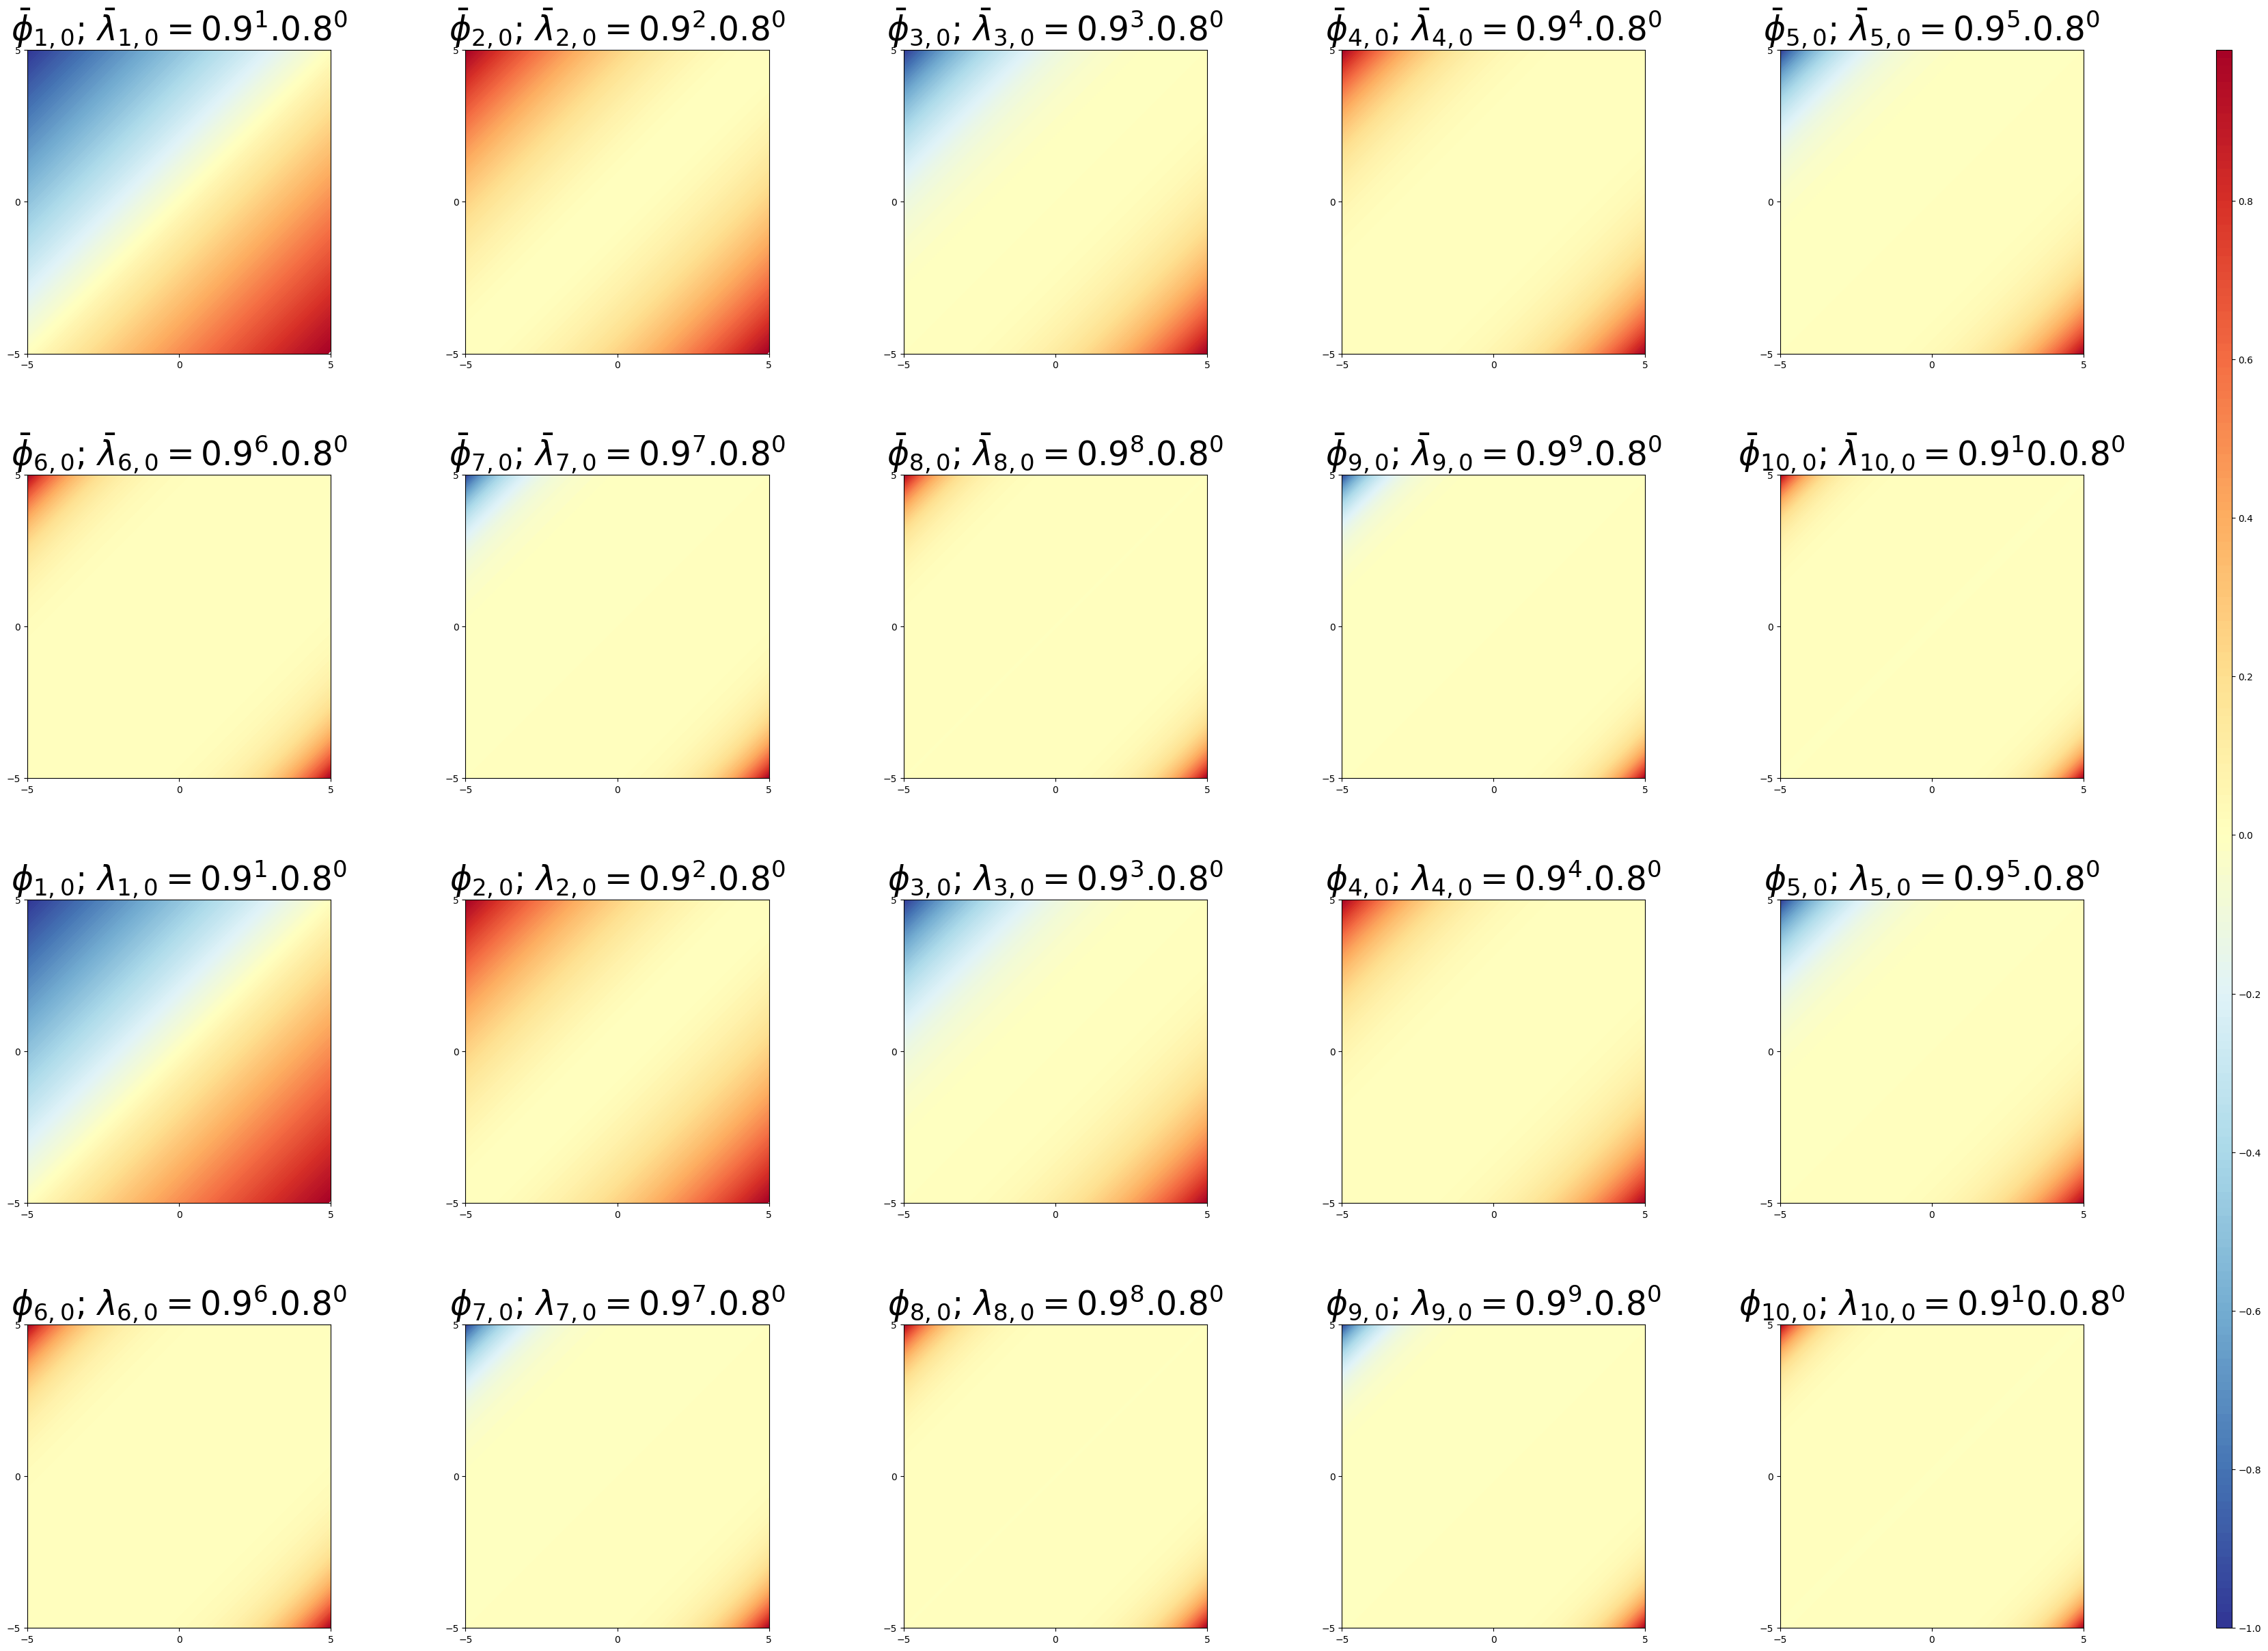

In [27]:
f, ax = plt.subplots(4, 5, figsize=(50,30))
plt.subplots_adjust(hspace=0.4)
error_list = []

c = 0
for i, (m,n) in enumerate(sorted_eig):
    Z_l = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=n, 
                                                  normalize=False)
    Z_l = Z_l.reshape(X.shape)
    Z_l_norm = Z_l/np.max(np.abs(Z_l))
    
    eigvalue_i_c = koopman_eigen_dmd.left_koopman_eigvals[0]
    eigvalue_j_c = koopman_eigen_dmd.left_koopman_eigvals[1]
    eig_c = (eigvalue_i_c)**m * (eigvalue_j_c) ** n
    eig_str_c = "$\\bar{\lambda}_{" + f"{m},{n}" + "}" + f"= {eigvalue_i_c:.3}^{m} . {eigvalue_j_c:.3}^{n}$"
    
    if n ==0:
        row = 1 if c>4 else 0
        h = ax[row][c%5].contourf(X, Y, Z_l_norm, cmap='RdYlBu_r', levels=np.arange(-1,1,0.01), vmin=-1, vmax=1)
#         plt.colorbar(h, orientation='horizontal')
        ax[row][c%5].set_title("$\\bar{\phi}_{" + f"{m},{n}" + "}$; " + eig_str_c, fontsize=35)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])
        ax[row][c%5].set_aspect('equal')

    Z = linear_system.generate_eigenfunction(X, Y, m,n)
    Z_norm = Z/np.max(np.abs(Z))
    
    eig = (eigvalue_i)**m * (eigvalue_j) ** n
    eig_str = "$\lambda_{" + f"{m},{n}" + "}" + f"= {eigvalue_i:.3}^{m} . {eigvalue_j:.3}^{n}$"

    if n ==0:
        row = 3 if c>4 else 2
        h = ax[row][c%5].contourf(X, Y, Z_norm, cmap='RdYlBu_r', levels=np.arange(-1,1,0.01), vmin=-1, vmax=1)
#         plt.colorbar(h, orientation='horizontal')
    
        ax[row][c%5].set_title("$\phi_{" + f"{m},{n}" + "}$; " + eig_str, fontsize=35)
        ax[row][c%5].set_xticks([ax[row][c%5].get_xlim()[0], 0, ax[row][c%5].get_xlim()[1]])
        ax[row][c%5].set_yticks([ax[row][c%5].get_ylim()[0], 0, ax[row][c%5].get_ylim()[1]])

        ax[row][c%5].set_aspect('equal')

        c=c+1
    
   
    
    error = min(np.linalg.norm(Z - Z_l), np.linalg.norm(Z + Z_l))
    error_list.append({"m": m, "n":n, "error": error}) 

cbar = f.colorbar(h, ax=ax.ravel().tolist(), aspect=100)

plt.savefig('plots/DMD_extended_eigfuncs_powers_p.png', bbox_inches='tight', dpi=400)
plt.show()

/var/folders/6l/vzg125jx7pq0xl02_m9tfbnr0000gn/T/ipykernel_1345/2328519320.py:12: RuntimeWarning: divide by zero encountered in log10
  col = np.array([np.log10(d["error"]) for d in error_list if d["m"]==0])


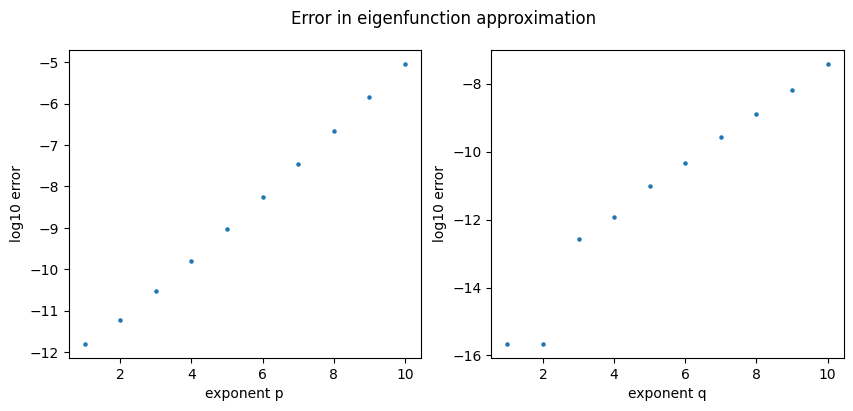

In [39]:
f, ax = plt.subplots(1,2, figsize=(10,4))

m_list = [d["m"] for d in error_list if d["n"]==0]
col = np.array([np.log10(d["error"]) for d in error_list if d["n"]==0])
col[col==-np.inf] = np.log10(np.finfo(np.float64).eps)

ax[0].scatter(m_list, col, s=5)
ax[0].set_xlabel('exponent p')
ax[0].set_ylabel('log10 error')

n_list = [d["n"] for d in error_list if d["m"]==0]
col = np.array([np.log10(d["error"]) for d in error_list if d["m"]==0])
col[col==-np.inf] = np.log10(np.finfo(np.float64).eps)

ax[1].scatter(n_list, col, s=5)

ax[1].set_xlabel('exponent q')
ax[1].set_ylabel('log10 error')


f.suptitle('Error in eigenfunction approximation')
plt.savefig('plots/error_DMD_eigfunc_approx.png', bbox_inches='tight', dpi=400)
plt.show()

### checking if eigenvectors lie in span

map from eigenvector space to function space, take power and map back to eigenvector space

In [42]:
x_flat.shape

(10000, 2)

In [49]:
eigfunc = koopman_eigen_dmd.extend_eigenfunctions(tsc_data, eigenvector_indexes=[0,1], pow_i=0, pow_j=2, 
                                                  normalize=True)
eigvec_new, residual, _, _ = np.linalg.lstsq(np.array(tsc_data) , np.array(eigfunc), rcond=1e-8)
eigvec_new, residual

(array([-2.35685063e-18, -5.36183519e-17]), array([137.29779385]))

In [50]:
eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=0, pow_j=2, 
                                                  normalize=True)
eigvec_new, residual, _, _ = np.linalg.lstsq(np.array(x_flat) , np.array(eigfunc), rcond=1e-8)
eigvec_new, residual

(array([-7.61531301e-18, -4.79764720e-17]), array([2081.34674638]))

In [79]:
m_pow_residual_dict = {}
for m in range(1, 11):
    eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=m, pow_j=0, 
                                                  normalize=True)
    eigvec_new, residual, _, _ = np.linalg.lstsq(x_flat , np.array(eigfunc), rcond=1e-8)
    eigvec_new, residual
    m_dict = {"residual": residual[0]}
    
    if residual<1:
        eigval_approx = koopman_eigen_dmd.left_koopman_eigvals[0] ** m
        eig_eq_norm = np.linalg.norm(koopman_eigen_dmd.koopman_matrix.T@eigvec_new - eigval_approx*eigvec_new)
        m_dict["eig_eq_norm"] = eig_eq_norm
    m_pow_residual_dict[m] = m_dict

        
    
n_pow_residual_dict = {}
for n in range(1, 11):
    eigfunc = koopman_eigen_dmd.extend_eigenfunctions(x_flat, eigenvector_indexes=[0,1], pow_i=0, pow_j=n, 
                                                  normalize=True)
    eigvec_new, residual, _, _ = np.linalg.lstsq(x_flat , np.array(eigfunc), rcond=1e-8)
    eigvec_new, residual
    n_dict = {"residual": residual[0]}
    
    if residual<1:
        eigval_approx = koopman_eigen_dmd.left_koopman_eigvals[1] ** n
        eig_eq_norm = np.linalg.norm(koopman_eigen_dmd.koopman_matrix.T@eigvec_new - eigval_approx*eigvec_new)
        n_dict["eig_eq_norm"] = eig_eq_norm
    n_pow_residual_dict[n] = n_dict

In [80]:
m_pow_residual_dict, n_pow_residual_dict

({1: {'residual': 4.924586573201283e-25, 'eig_eq_norm': 2.636779683484747e-16},
  2: {'residual': 693.840077474399},
  3: {'residual': 96.03622713991987},
  4: {'residual': 240.6468479933539},
  5: {'residual': 82.79874642186549},
  6: {'residual': 123.78770970191229},
  7: {'residual': 61.67355786193326},
  8: {'residual': 76.56634600833729},
  9: {'residual': 46.39822896649721},
  10: {'residual': 52.7244493518145}},
 {1: {'residual': 1.9563957535702132e-27,
   'eig_eq_norm': 1.8146100392243783e-18},
  2: {'residual': 2081.3467463809247},
  3: {'residual': 242.43903677461606},
  4: {'residual': 1202.6928333208919},
  5: {'residual': 327.26902721074566},
  6: {'residual': 865.5758445699349},
  7: {'residual': 339.360684159302},
  8: {'residual': 687.7324629931634},
  9: {'residual': 331.06008248044566},
  10: {'residual': 578.1469542041664}})

In [85]:
pd.DataFrame(m_pow_residual_dict)

,1,2,3,4,5,6,7,8,9,10
residual,4.924587e-25,693.840077,96.036227,240.646848,82.798746,123.78771,61.673558,76.566346,46.398229,52.724449
eig_eq_norm,2.636780e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df = pd.DataFrame(m_pow_residual_dict).T
df.insert(0, "power p", df.index)
latex_table = df.to_latex(na_rep="-", index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{rrr}
\toprule
 power p &     residual &  eig\_eq\_norm \\
\midrule
       1 & 4.924587e-25 & 2.636780e-16 \\
       2 & 6.938401e+02 &            - \\
       3 & 9.603623e+01 &            - \\
       4 & 2.406468e+02 &            - \\
       5 & 8.279875e+01 &            - \\
       6 & 1.237877e+02 &            - \\
       7 & 6.167356e+01 &            - \\
       8 & 7.656635e+01 &            - \\
       9 & 4.639823e+01 &            - \\
      10 & 5.272445e+01 &            - \\
\bottomrule
\end{tabular}



In [102]:
df = pd.DataFrame(n_pow_residual_dict).T
df.insert(0, "power q", df.index)
latex_table = df.to_latex(na_rep="-", index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{rrr}
\toprule
 power q &     residual &  eig\_eq\_norm \\
\midrule
       1 & 1.956396e-27 & 1.814610e-18 \\
       2 & 2.081347e+03 &            - \\
       3 & 2.424390e+02 &            - \\
       4 & 1.202693e+03 &            - \\
       5 & 3.272690e+02 &            - \\
       6 & 8.655758e+02 &            - \\
       7 & 3.393607e+02 &            - \\
       8 & 6.877325e+02 &            - \\
       9 & 3.310601e+02 &            - \\
      10 & 5.781470e+02 &            - \\
\bottomrule
\end{tabular}



In [175]:
# if residual is too high and we get zero solution it means that the eigenfunction does not lie in the span of x1,x2

In [176]:
# also means that there is no 2d vector which can make the given eigenfunction as eigenfunction

### reconstructing observables using new eigenfunctions

In [168]:
sinx_df = np.sin(tsc_data).to_numpy()
sinx_df.shape

(800, 2)

#### reconstruct sinx using in-sample data

In [169]:
eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(tsc_data.to_numpy())
eigfunc_matrix.shape

(800, 2)

In [246]:
sinx_recons_df = koopman_eigen_dmd.reconstruct_observable(sinx_df, eigfunc_matrix)
sinx_recons_df.shape

(800, 2)

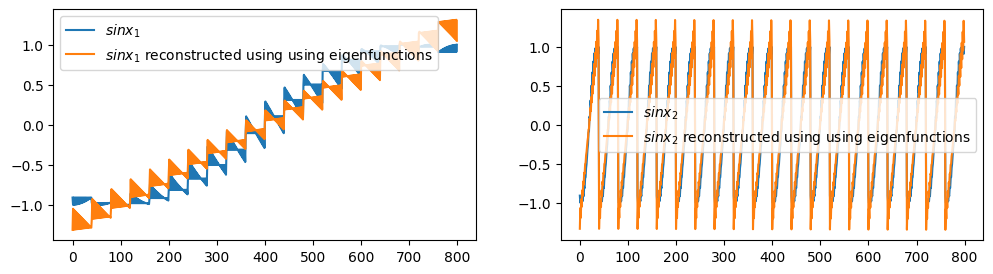

In [247]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(sinx_df[:,0], label="$sin x_1$")
ax[0].plot(sinx_recons_df[:,0], label="$sinx_1$ reconstructed using using eigenfunctions")
ax[0].legend()

ax[1].plot(sinx_df[:,1], label="$sinx_2$")
ax[1].plot(sinx_recons_df[:,1], label="$sinx_2$ reconstructed using using eigenfunctions")
ax[1].legend()


#### reconstruct sinx using out of sample data

In [270]:
x = np.linspace(-3*np.pi, 3*np.pi, 100)
y = np.linspace(-3*np.pi, 3*np.pi, 100)

oos_grid = np.array([x, y]).T
sinx_oos_grid = np.sin(oos_grid)

eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(oos_grid)
eigfunc_matrix.shape

(100, 2)

In [271]:
sinx_oos_recons_orig = koopman_eigen_dmd.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
sinx_oos_recons_orig.shape

(100, 2)

In [272]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid,eigvector_idx = [0,1], exp_pairs=exp_pairs)
print(f"extended eigenfunction matrix shape: ", eigfunc_matrix.shape)

sinx_oos_recons_14 = koopman_eigen_dmd.reconstruct_observable(sinx_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sinx_oos_recons_14.shape)

extended eigenfunction matrix shape:  (100, 15)
reconstructed observable shape:  (100, 2)


#### reconstruct using an extended set of eigenfunctions

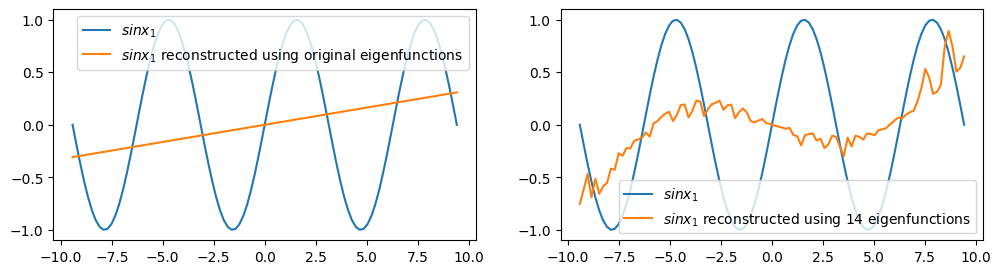

In [273]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[0].plot(oos_grid[:,0], sinx_oos_recons_orig[:,0], label="$sinx_1$ reconstructed using original eigenfunctions")
ax[0].legend()

ax[1].plot(oos_grid[:,0], sinx_oos_grid[:,0], label="$sin x_1$")
ax[1].plot(oos_grid[:,0], sinx_oos_recons_14[:,0], label="$sinx_1$ reconstructed using 14 eigenfunctions")
ax[1].legend()

#### reconstructing sin(x1)cos(x2)

In [274]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data for the contour plot
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

oos_grid = np.array([X.flatten(), Y.flatten()]).T
sincos_oos_grid = (np.sin(X) * np.cos(Y)).flatten()
oos_grid.shape, sincos_oos_grid.shape

((10000, 2), (10000,))

In [275]:
eigfunc_matrix = koopman_eigen_dmd.eigenfunction_left(koopman_eigen_dmd.left_koopman_eigvecs)(oos_grid)

sincos_oos_recons_orig = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
sincos_oos_recons_orig.shape

(10000,)

In [276]:
exp_pairs = [(i,j) for i in range(0,4) for j in range(0,4)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,1], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_14 = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_14.shape)

eigenfunction matrix shape:  (10000, 15)
reconstructed observable shape:  (10000,)


In [277]:
exp_pairs = [(i,j) for i in range(0,5) for j in range(0,5)]

eigfunc_matrix = koopman_eigen_dmd.extended_eigfunction_matrix(oos_grid, eigvector_idx = [0,1], exp_pairs=exp_pairs)
print("eigenfunction matrix shape: ", eigfunc_matrix.shape)

sincos_oos_recons_24 = koopman_eigen_dmd.reconstruct_observable(sincos_oos_grid, eigfunc_matrix)
print("reconstructed observable shape: ", sincos_oos_recons_24.shape)

eigenfunction matrix shape:  (10000, 24)
reconstructed observable shape:  (10000,)


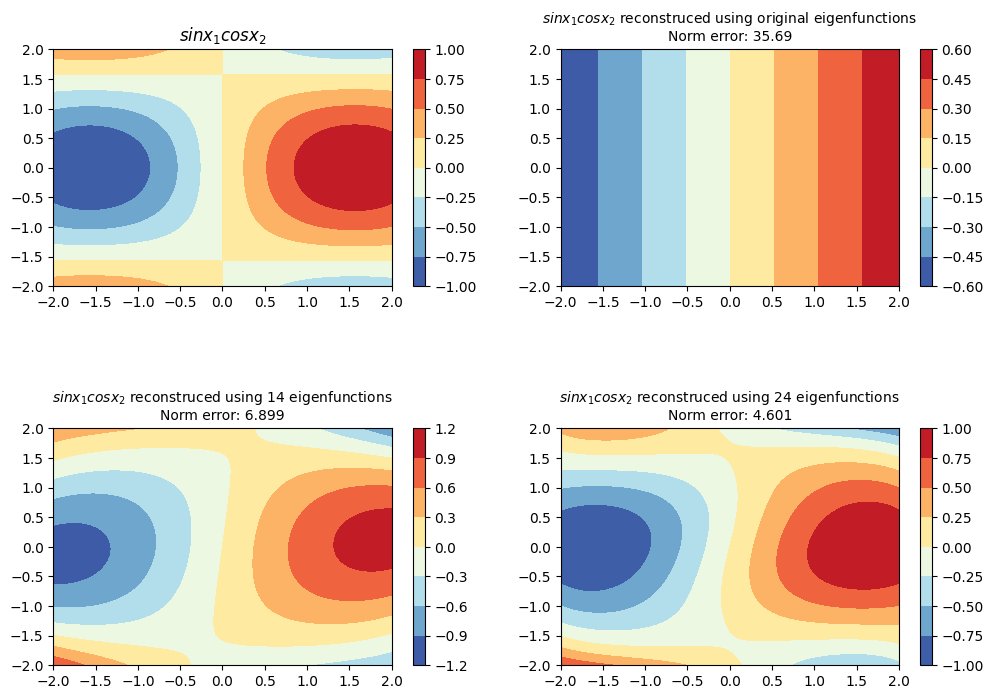

In [278]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.subplots_adjust(hspace=0.6)


h = ax[0][0].contourf(X, Y, sincos_oos_grid.reshape(100,100), cmap='RdYlBu_r')
ax[0][0].set_title("$sinx_1cosx_2$")
plt.colorbar(h)

k = ax[0][1].contourf(X, Y, sincos_oos_recons_orig.reshape(100,100), cmap='RdYlBu_r')
ax[0][1].set_title(f"$sinx_1cosx_2$ reconstruced using original eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_orig):.4}",
                   fontsize=10)
plt.colorbar(k)

l = ax[1][0].contourf(X, Y, sincos_oos_recons_14.reshape(100,100), cmap='RdYlBu_r')
ax[1][0].set_title(f"$sinx_1cosx_2$ reconstruced using 14 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_14):.4}",
                  fontsize=10)
plt.colorbar(l)

m = ax[1][1].contourf(X, Y, sincos_oos_recons_24.reshape(100,100), cmap='RdYlBu_r')
ax[1][1].set_title(f"$sinx_1cosx_2$ reconstruced using 24 eigenfunctions\nNorm error: {np.linalg.norm(sincos_oos_grid-sincos_oos_recons_24):.4}",
                  fontsize=10)
plt.colorbar(m)
